# Analisis Data Film IFEST DAC 2025 
## DuoChandra+1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

import os
import re


from warnings import filterwarnings
filterwarnings("ignore")

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import tmdbsimple as tmdb
from dotenv import load_dotenv

load_dotenv()

TMDB_API_KEY = os.getenv("TMDB_API_KEY")
DATASET_PATH = "./dataset_ifest_2025.csv"

from time import sleep
import json

In [2]:
# ========================
# GLOBAL CONFIGURATION - Font Size for All Visualizations
# ========================
# Set large, readable font sizes for all plots
GLOBAL_FONT_SIZE = 16  # Base font size - large for readability
TITLE_FONT_SIZE = GLOBAL_FONT_SIZE + 4  # 20pt for titles
LABEL_FONT_SIZE = GLOBAL_FONT_SIZE + 2  # 18pt for axis labels  
TICK_FONT_SIZE = GLOBAL_FONT_SIZE - 2   # 14pt for tick labels
LEGEND_FONT_SIZE = GLOBAL_FONT_SIZE     # 16pt for legends
ANNOTATION_FONT_SIZE = GLOBAL_FONT_SIZE - 2  # 14pt for annotations

# Configure matplotlib defaults for better readability
plt.rcParams.update({
    'font.size': GLOBAL_FONT_SIZE,
    'axes.titlesize': TITLE_FONT_SIZE,
    'axes.labelsize': LABEL_FONT_SIZE,
    'xtick.labelsize': TICK_FONT_SIZE,
    'ytick.labelsize': TICK_FONT_SIZE,
    'legend.fontsize': LEGEND_FONT_SIZE,
    'figure.titlesize': TITLE_FONT_SIZE + 2,
    'font.weight': 'normal'
})

print(f"✅ Global font configuration set:")
print(f"   Base font size: {GLOBAL_FONT_SIZE}pt")
print(f"   Title font size: {TITLE_FONT_SIZE}pt") 
print(f"   Label font size: {LABEL_FONT_SIZE}pt")
print(f"   Tick font size: {TICK_FONT_SIZE}pt")
print(f"   All plots will use these large, readable fonts!")

✅ Global font configuration set:
   Base font size: 16pt
   Title font size: 20pt
   Label font size: 18pt
   Tick font size: 14pt
   All plots will use these large, readable fonts!


In [3]:
df = pd.read_csv(DATASET_PATH)
df

,movie_title,genre_label,language,summary,popularity,release_date
0,Ace Ventura: When Nature Calls,"Crime,Comedy,Adventure",en,"Summoned from an ashram in Tibet, Ace finds hi...",28.877,1995-11-10
1,The Wave,Thriller,no,"Although theorised, no one is really ready whe...",28.675,2015-08-28
2,Spotlight,NaN,en,The true story of how the Boston Globe uncover...,13.601,2015-11-06
3,The Medallion,"Thriller,Fantasy,Action,Comedy",en,A Hong Kong detective suffers a fatal accident...,17.180,2003-08-15
4,Caro diario,NaN,it,Nanni Moretti recalls in his diary three slice...,6.270,1993-10-12
...,...,...,...,...,...,...
12994,In the Blood,NaN,en,When her husband goes missing during their Car...,17.683,2014-04-04
12995,Little White Lies 2,"Comedy,Drama",fr,"The result of the small handkerchiefs ""Petits ...",12.326,2019-05-01
12996,Twins,Comedy,en,Julius and Vincent Benedict are the results of...,21.198,1988-12-08
12997,Teen Wolf,"Comedy,Fantasy,Romance",en,When a shy teenager's new-found powers help hi...,35.726,1985-08-23


## Data Overview 


=== DATA OVERVIEW ===
Jumlah baris (film): 12,999
Jumlah kolom: 6

Missing value per kolom:
              Missing  Missing %
movie_title         0   0.000000
genre_label      2000  15.385799
language            0   0.000000
summary             5   0.038464
popularity          0   0.000000
release_date        0   0.000000

Jumlah baris duplikat (seluruh kolom sama persis): 3008

Jumlah judul film yang merupakan remake/sekuel (judul sama, rilis beda): 314
Contoh judul remake (max 5):
['12 Angry Men', '3:10 to Yuma', '9', 'A Christmas Carol', 'A Nightmare on Elm Street']

Statistik Popularitas:
count    12999.000000
mean        33.225649
std        189.045262
min          0.600000
25%          9.119500
50%         13.577000
75%         25.405000
max      10436.917000
Name: popularity, dtype: float64
Skewness: 38.05
Kurtosis: 1725.55


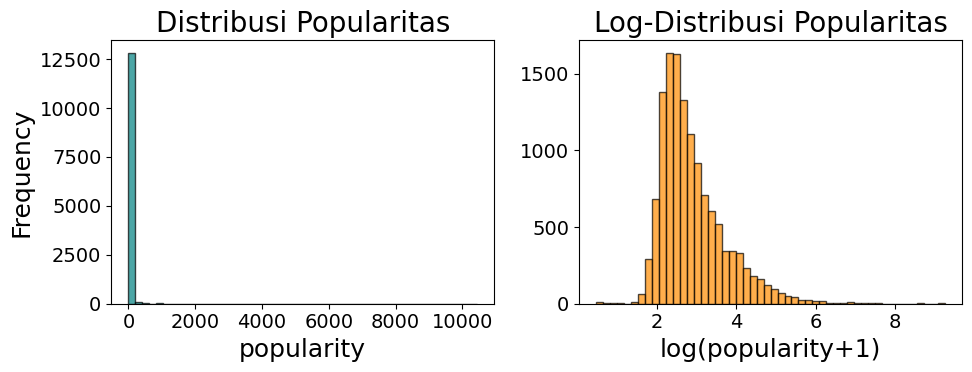

In [4]:
# --- 1. Ukuran dataset
print("\n=== DATA OVERVIEW ===")
print(f"Jumlah baris (film): {df.shape[0]:,}")
print(f"Jumlah kolom: {df.shape[1]}")

# --- 2. Missing value per kolom
missing = df.isna().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({'Missing': missing, 'Missing %': missing_pct})
print("\nMissing value per kolom:")
print(missing_df)

# --- 3. Jumlah baris duplikat (seluruh kolom)
n_full_dupes = df.duplicated().sum()
print(f"\nJumlah baris duplikat (seluruh kolom sama persis): {n_full_dupes}")

# --- 4. Film remake/duplikat judul (judul sama, tanggal beda)
if 'movie_title' in df.columns and 'release_date' in df.columns:
    dupe_judul = df.duplicated(subset=['movie_title'], keep=False)
    remake_groups = df[dupe_judul].groupby('movie_title')['release_date'].nunique()
    n_remake = (remake_groups >= 2).sum()
    print(f"\nJumlah judul film yang merupakan remake/sekuel (judul sama, rilis beda): {n_remake}")
    print("Contoh judul remake (max 5):")
    print(remake_groups[remake_groups >= 2].head().index.tolist())
else:
    print("movie_title/release_date tidak ditemukan di dataframe.")

# --- 5. Distribusi Target (popularity)
if 'popularity' in df.columns:
    print(f"\nStatistik Popularitas:")
    print(df['popularity'].describe())
    print(f"Skewness: {df['popularity'].skew():.2f}")
    print(f"Kurtosis: {df['popularity'].kurtosis():.2f}")

    # Plot distribusi
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(df['popularity'].dropna(), bins=50, color='teal', alpha=0.7, edgecolor='k')
    plt.title("Distribusi Popularitas", fontsize=TITLE_FONT_SIZE)
    plt.xlabel("popularity", fontsize=LABEL_FONT_SIZE)
    plt.ylabel("Frequency", fontsize=LABEL_FONT_SIZE)
    plt.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE)

    plt.subplot(1,2,2)
    plt.hist(np.log1p(df['popularity'].dropna()), bins=50, color='darkorange', alpha=0.7, edgecolor='k')
    plt.title("Log-Distribusi Popularitas", fontsize=TITLE_FONT_SIZE)
    plt.xlabel("log(popularity+1)", fontsize=LABEL_FONT_SIZE)
    plt.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE)
    plt.tight_layout()
    plt.show()

else:    print("popularitas tidak ditemukan di kolom dataframe.")

In [5]:
class DuplicateRemover:
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = self.duplicate_remover(X)
        return X

    def duplicate_remover(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.drop_duplicates(subset=["movie_title", "release_date"])
        return df


class ExtractMainTitle:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        import en_core_web_sm

        self.nlp = en_core_web_sm.load()
        self.last_is_number_regex = r"( ([1-9]|one|two|three|four|five|six|seven|eight|nine|ten|i|ii|iii|iv|v|vi|vii))$"

    def has_sub_title(self, text: str):
        return ":" in text and not bool(re.search(r"[0-2][0-9]:[0-2][0-9]", text))

    def has_parts(self, text: str):
        return re.search(r"part ", text, re.IGNORECASE) is not None

    def is_sequel(self, text: str) -> bool:
        INVALID_END_POS = {"ADP", "PART", "DET", "CCONJ", "SCONJ"}
        if bool(re.search(self.last_is_number_regex, text, re.IGNORECASE)):
            # Check if the word before is not in the set
            doc = self.nlp(text)
            if len(doc) >= 2 and doc[-2].pos_ not in INVALID_END_POS:
                return True
        return False

    def remove_sequel_number(self, text: str) -> str:
        if self.is_sequel(text):
            return re.sub(
                self.last_is_number_regex, "", text, flags=re.IGNORECASE
            ).strip()
        else:
            return text

    def get_main_title(self, text: str) -> str:
        # If there is a sub title, get the main title
        text = text.lower()
        if self.has_sub_title(text):
            text = text.split(":")[0].strip()

        # If there is a "part", remove it and anything after it. Intuition: AoT Part 2: The Final Season -> AoT
        if self.has_parts(text):
            text = text.split("part ")[0].strip()
        return text.title()

    def has_multiple_movies(self, title: str) -> bool:
        return (
            self.has_sub_title(title) or self.has_parts(title) or self.is_sequel(title)
        )

    def is_prequel(self, text: str) -> bool:
        return self.has_parts(text)

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X["main_title"] = X["movie_title"].apply(self.get_main_title)
        X["main_title"] = X["main_title"].apply(self.remove_sequel_number)
        X["movie_has_multiple"] = X["movie_title"].apply(self.has_multiple_movies)
        X["movie_is_prequel"] = X["movie_title"].apply(self.is_prequel)
        return X


class ExtractGenre:
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def pool_genre_label(self, df: pd.DataFrame) -> str:
        df = df.copy()
        nan_mask_genre = df["genre_label"].isna()
        df_nan_genre = df[nan_mask_genre]
        df_not_nan_genre = df[~nan_mask_genre]
        if len(df_not_nan_genre) == 0:
            return None

        if len(df_nan_genre) == 0:
            return df
        counter = 0
        for idx, row in df_nan_genre.iterrows():
            main_title = row["main_title"]
            # Finding movies that contains the main title
            similar_movies = df_not_nan_genre[
                df_not_nan_genre["movie_title"].str.contains(
                    main_title, na=False, case=False
                )
            ]
            for _, sim_row in similar_movies.iterrows():
                if pd.notna(sim_row["genre_label"]):
                    df.at[idx, "genre_label"] = sim_row["genre_label"]
                    counter += 1
                    break
        return df

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = self.pool_genre_label(X)
        return X

In [6]:
df.isnull().sum()

movie_title        0
genre_label     2000
language           0
summary            5
popularity         0
release_date       0
dtype: int64

In [7]:
genres = tmdb.Genres().movie_list()['genres']
genres_dict = {genre['id']: genre['name'] for genre in genres}

In [8]:
class TMDBGenreFetcher:
    def __init__(self, api_key: str, genres_dict: dict = None):
        self.api_key = api_key
        tmdb.API_KEY = self.api_key
        self.search = tmdb.Search()
        # Use provided genres_dict or fetch from TMDB API as fallback
        self.genres_dict = (
            genres_dict
            if genres_dict is not None
            else {
                genre["id"]: genre["name"]
                for genre in tmdb.Genres().movie_list()["genres"]
            }
        )

    def decode_tmdb_genre(self, genre_ids: list) -> str:
        """Convert genre IDs to comma-separated genre names"""
        if not genre_ids:
            return pd.NA

        genre_names = [
            self.genres_dict.get(genre_id)
            for genre_id in genre_ids
            if genre_id in self.genres_dict
        ]
        # Making the output in the form of a comma separated string for consistency with the dataset
        return ",".join(genre_names) if genre_names else pd.NA

    def get_genre_from_tmdb(self, idx, movie_title: str, release_date: str = None):
        """Fetch genre for a single movie using tmdbsimple"""
        try:
            year = None
            if release_date and pd.notna(release_date):
                year = int(str(release_date).split("-")[0])

            # Search for the movie
            results = self.search.movie(query=movie_title, year=year)

            if results.get("results") and len(results["results"]) > 0:
                # Get the first result's genre_ids
                genre_ids = results["results"][0].get("genre_ids", [])
                return idx, self.decode_tmdb_genre(genre_ids)
            else:
                return idx, pd.NA

        except Exception as e:
            print(f"Error fetching genre for '{movie_title}': {e}")
            return idx, pd.NA

    def find_missing_genres_with_tmdb(self, df: pd.DataFrame) -> dict:
        """Find the missing genres using TMDB API. Returns a dictionary of {idx: genre_label}"""
        output = {}
        missing = df[df["genre_label"].isna()]

        print(f"Fetching genres for {len(missing)} missing entries using tmdbsimple...")

        for i, (idx, row) in enumerate(missing.iterrows()):
            if pd.isna(row["movie_title"]):
                continue

            if i % 50 == 0:  # Progress update every 50 requests
                print(f"Processed {i}/{len(missing)} requests...")

            movie_title = row["movie_title"]
            release_date = (
                row["release_date"] if pd.notna(row["release_date"]) else None
            )

            id_result, genre_label = self.get_genre_from_tmdb(
                idx, movie_title, release_date
            )
            output[id_result] = genre_label

            # Rate limiting - be nice to the API
            sleep(1/30)

        print(f"Completed fetching genres for {len(missing)} entries.")
        return output

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        # Try to load pre-saved results first
        try:
            with open("tmdb_genre_results.json", "r") as f:
                result = json.load(f)
            print("Loading genres from saved results...")

            for k, v in result.items():
                if int(k) in X.index and pd.notna(v):
                    X.at[int(k), "genre_label"] = v

        except FileNotFoundError:
            print("No saved results found, fetching from TMDB API...")

        # Check if there are still missing genres after loading saved results
        remaining_missing = X["genre_label"].isna().sum()
        if remaining_missing > 0:
            # Fetch missing genres from TMDB API
            missing_genres = self.find_missing_genres_with_tmdb(X)
            # Apply the fetched genres
            for idx, genre_label in missing_genres.items():
                if pd.notna(genre_label):
                    X.at[idx, "genre_label"] = genre_label

            # Save results for future use
            try:
                # Load existing results if any
                try:
                    with open("tmdb_genre_results.json", "r") as f:
                        existing_results = json.load(f)
                except FileNotFoundError:
                    existing_results = {}

                # Add new results
                for k, v in missing_genres.items():
                    if pd.notna(v):
                        existing_results[str(k)] = v

                # Save combined results
                with open("tmdb_genre_results.json", "w") as f:
                    json.dump(existing_results, f)
                print("Saved results to tmdb_genre_results.json")

            except Exception as e:
                print(f"Error saving results: {e}")

        return X

In [9]:
class FeatureExtractor:
    def __init__(self, genres: list = None):
        # Use provided genres or fetch from TMDB API as fallback
        if genres is not None:
            self.genres = genres
        else:
            self.genres = tmdb.Genres().movie_list()["genres"]

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        # Get the genres as One-Hot Encoded features
        for genre_dict in self.genres:
            genre_name = genre_dict["name"]
            column_name = f"genre_{genre_name.lower().replace(' ', '_')}"
            X[column_name] = X["genre_label"].apply(
                lambda x: 1 if pd.notna(x) and genre_name in str(x) else 0
            )

        # Extract release year
        X["release_year"] = X["release_date"].str[:4]

        return X

In [ ]:
# Create the pipeline using already fetched genres
pipe = Pipeline(
    [
        ("extract_main_title", ExtractMainTitle()),
        ("extract_genre", ExtractGenre()),
        ("duplicate_remover", DuplicateRemover()),
        ("tmdb_genre_fetcher", TMDBGenreFetcher(TMDB_API_KEY, genres_dict)),
        ("feature_extractor", FeatureExtractor(genres)),
    ]
)

print("Pipeline created successfully!")
print("Pipeline steps:")
for i, (name, transformer) in enumerate(pipe.steps, 1):
    print(f"  {i}. {name}: {transformer.__class__.__name__}")

df_cleaned = pipe.fit_transform(df)

In [ ]:
a = df_cleaned.copy()
nan_mask_genre = a["genre_label"].isna()
df_nan_genre = a[nan_mask_genre]
df_not_nan_genre = a[~nan_mask_genre]
if len(df_not_nan_genre) == 0:
    print("No non-NaN genre labels available to pool from.")

if len(df_nan_genre) == 0:
    print("No NaN genre labels to pool.")

if len(df_not_nan_genre) > 0 and len(df_nan_genre) > 0:
    print(f"Pooling genres for {len(df_nan_genre)} entries...")
    counter = 0
    for idx, row in df_nan_genre.iterrows():
        main_title = row["main_title"]
        print(f"Processing index {idx}, main title: {main_title}")
        # Finding movies that contains the main title
        similar_movies = df_not_nan_genre[
            df_not_nan_genre["movie_title"].str.contains(
                main_title, na=False, case=False
            )
        ]
        print(f"Found {len(similar_movies)} similar movies for '{main_title}'")
        for _, sim_row in similar_movies.iterrows():
            if pd.notna(sim_row["genre_label"]):
                df.at[idx, "genre_label"] = sim_row["genre_label"]
                counter += 1
                break

Pooling genres for 4 entries...
Processing index 1513, main title: Nicky Larson And The Cupid'S Perfume
Found 0 similar movies for 'Nicky Larson And The Cupid'S Perfume'
Processing index 1556, main title: Our Summer In Provence
Found 0 similar movies for 'Our Summer In Provence'
Processing index 7374, main title: What A Beautiful Surprise
Found 0 similar movies for 'What A Beautiful Surprise'
Processing index 11105, main title: The Ox-Bow Incident
Found 0 similar movies for 'The Ox-Bow Incident'


In [ ]:
df_cleaned = df_cleaned.dropna(subset=["genre_label"]).reset_index(drop=True)
df_cleaned = df_cleaned.dropna(subset=["summary"]).reset_index(drop=True)
print(df_cleaned.info())
df_cleaned.to_csv("cleaned_dataset.csv", index=False)
df_cleaned.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movie_title            9983 non-null   object 
 1   genre_label            9983 non-null   object 
 2   language               9983 non-null   object 
 3   summary                9983 non-null   object 
 4   popularity             9983 non-null   float64
 5   release_date           9983 non-null   object 
 6   main_title             9983 non-null   object 
 7   movie_has_multiple     9983 non-null   bool   
 8   movie_is_prequel       9983 non-null   bool   
 9   genre_action           9983 non-null   int64  
 10  genre_adventure        9983 non-null   int64  
 11  genre_animation        9983 non-null   int64  
 12  genre_comedy           9983 non-null   int64  
 13  genre_crime            9983 non-null   int64  
 14  genre_documentary      9983 non-null   int64  
 15  genr

movie_title              0
genre_label              0
language                 0
summary                  0
popularity               0
release_date             0
main_title               0
movie_has_multiple       0
movie_is_prequel         0
genre_action             0
genre_adventure          0
genre_animation          0
genre_comedy             0
genre_crime              0
genre_documentary        0
genre_drama              0
genre_family             0
genre_fantasy            0
genre_history            0
genre_horror             0
genre_music              0
genre_mystery            0
genre_romance            0
genre_science_fiction    0
genre_tv_movie           0
genre_thriller           0
genre_war                0
genre_western            0
release_year             0
dtype: int64

## Eksplorasi Data 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df_cleaned = pd.read_csv("cleaned_dataset.csv")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class Visualizer:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

        # safer year extraction
        years = pd.to_datetime(self.df.get('release_date'), errors='coerce').dt.year
        self.df['release_year'] = pd.to_numeric(years, errors='coerce')

        # global font fallbacks
        self.font_size = globals().get('GLOBAL_FONT_SIZE', 10)
        self.title_size = globals().get('TITLE_FONT_SIZE', 14)
        self.label_size = globals().get('LABEL_FONT_SIZE', 12)
        self.tick_size = globals().get('TICK_FONT_SIZE', 10)
        self.legend_size = globals().get('LEGEND_FONT_SIZE', 10)
        self.annotation_size = globals().get('ANNOTATION_FONT_SIZE', 9)

    # --- helpers ---
    def _safe_log_floor(self, s: pd.Series, eps: float = 1e-8) -> pd.Series:
        """Ensure strictly-positive values before log-scale axes."""
        return s.clip(lower=eps)

    def _genre_onehot_cols(self) -> list[str]:
        return [c for c in self.df.columns if c.startswith("genre_") and c != "genre_label"]

    # 1) Time vs Popularity
    def plot_popularity_over_period_boxplot(self, figsize=(10, 5)):
        plot_df = self.df.dropna(subset=['release_year', 'popularity']).copy()
        plot_df = plot_df[plot_df['release_year'] >= 1900]
        plot_df['year_bin'] = pd.cut(plot_df['release_year'], bins=range(1900, 2026, 25))
        plot_df['popularity'] = self._safe_log_floor(plot_df['popularity'])

        fig, ax = plt.subplots(figsize=figsize)
        sns.boxplot(x='year_bin', y='popularity', data=plot_df, ax=ax)
        ax.set_yscale('log')
        ax.set_xlabel('Year Bins', fontsize=self.label_size)
        ax.set_ylabel('Popularity (log scale axis)', fontsize=self.label_size)
        ax.set_title('Popularity of Movies by Year Bins', fontsize=self.title_size)
        ax.tick_params(axis='both', which='major', labelsize=self.tick_size)
        return ax

    def plot_q1_q2_q3_popularity_over_period(self, figsize=(12, 5)):
        plot_df = self.df.dropna(subset=['release_year', 'popularity']).copy()
        plot_df = plot_df[plot_df['release_year'] >= 1900]
        plot_df['year_bin'] = pd.cut(plot_df['release_year'], bins=range(1900, 2026, 10))

        q1 = plot_df.groupby('year_bin')['popularity'].quantile(0.25).reset_index(name='Q1')
        q2 = plot_df.groupby('year_bin')['popularity'].quantile(0.50).reset_index(name='Q2')
        q3 = plot_df.groupby('year_bin')['popularity'].quantile(0.75).reset_index(name='Q3')

        fig, ax = plt.subplots(figsize=figsize)
        x = q1['year_bin'].astype(str)
        ax.plot(x, q1['Q1'], marker='o', label='Q1 (25th Percentile)')
        ax.plot(x, q2['Q2'], marker='o', label='Q2 (Median)')
        ax.plot(x, q3['Q3'], marker='o', label='Q3 (75th Percentile)')
        ax.set_xlabel('Year Bins', fontsize=self.label_size)
        ax.set_ylabel('Popularity', fontsize=self.label_size)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=-60, fontsize=self.tick_size)
        ax.set_title('Popularity Quantiles of Movies by Year Bins', fontsize=self.title_size)
        ax.legend(fontsize=self.legend_size)
        ax.tick_params(axis='y', which='major', labelsize=self.tick_size)
        return ax

    # 2) Number of Genre vs Popularity
    def plot_number_of_genre_and_popularity_boxplot(self, figsize=(8, 5)):
        genre_cols = self._genre_onehot_cols()
        if not genre_cols:
            raise ValueError("No one-hot genre columns found (expected columns starting with 'genre_').")

        plot_df = self.df[genre_cols].copy()
        plot_df['num_genres'] = plot_df.sum(axis=1, numeric_only=True)
        plot_df['popularity'] = self.df['popularity']
        plot_df = plot_df[['num_genres', 'popularity']].dropna().copy()
        plot_df['popularity'] = self._safe_log_floor(plot_df['popularity'])

        fig, ax = plt.subplots(figsize=figsize)
        sns.boxplot(x='num_genres', y='popularity', data=plot_df, ax=ax)
        ax.set_yscale('log')
        ax.set_xlabel('Number of Genres', fontsize=self.label_size)
        ax.set_ylabel('Popularity (log scale)', fontsize=self.label_size)
        ax.set_title('Popularity vs Number of Genres', fontsize=self.title_size)
        ax.tick_params(axis='both', which='major', labelsize=self.tick_size)
        return ax

    def plot_number_of_genre_and_popularity_line_plot(self, figsize=(8, 5)):
        genre_cols = self._genre_onehot_cols()
        if not genre_cols:
            raise ValueError("No one-hot genre columns found (expected columns starting with 'genre_').")

        plot_df = self.df[genre_cols].copy()
        plot_df['num_genres'] = plot_df.sum(axis=1, numeric_only=True)
        plot_df['popularity'] = self.df['popularity']
        plot_df = plot_df[['num_genres', 'popularity']].dropna().copy()

        grouped = plot_df.groupby('num_genres', as_index=False)['popularity'].median()

        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(grouped['num_genres'], grouped['popularity'], marker='o')
        ax.set_xlabel('Number of Genres', fontsize=self.label_size)
        ax.set_ylabel('Median Popularity', fontsize=self.label_size)
        ax.set_title('Median Popularity vs Number of Genres', fontsize=self.title_size)
        ax.tick_params(axis='both', which='major', labelsize=self.tick_size)
        return ax

    # 3) Language vs Popularity
    def plot_language_and_popularity_with_counts(self, figsize=(12, 6), min_count=100):
        plot_df = self.df[["language", "popularity"]].dropna().copy()
        counts = plot_df['language'].value_counts()
        valid = counts[counts >= min_count].index
        plot_df = plot_df[plot_df['language'].isin(valid)].copy()
        if plot_df.empty:
            raise ValueError(f"No languages with at least {min_count} entries.")

        plot_df['popularity'] = self._safe_log_floor(plot_df['popularity'])

        med = plot_df.groupby("language")["popularity"].median().sort_values(ascending=False)
        ordered = med.index.tolist()
        counts_filtered = plot_df['language'].value_counts()

        fig, ax = plt.subplots(figsize=figsize)
        ax.set_yscale("log")
        sns.boxplot(x="language", y="popularity", data=plot_df, ax=ax, order=ordered)

        overall_max = plot_df["popularity"].max()

        for i, lang in enumerate(ordered):
            lang_data = plot_df.loc[plot_df["language"] == lang, "popularity"]
            max_val = lang_data.max()
            count = int(counts_filtered.get(lang, 0))
            ax.annotate(
                f"n={count}",
                xy=(i, max_val),
                xytext=(0, 12),
                textcoords="offset points",
                va="bottom",
                fontsize=self.annotation_size,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", linewidth=1),
            )

        ax.set_ylim(bottom=plot_df["popularity"].min() * 0.8, top=overall_max * 2.5)
        ax.set_xlabel("Language", fontsize=self.label_size)
        ax.set_ylabel("Popularity (log scale)", fontsize=self.label_size)
        ax.set_title(
            "Popularity vs Language with Count Annotations\n(Ordered by Median Popularity)",
            fontsize=self.title_size,
        )
        ax.tick_params(axis="x", rotation=45, labelsize=self.tick_size)
        ax.tick_params(axis="y", labelsize=self.tick_size)
        plt.tight_layout()
        return ax

    # --- internals for remakes/percentiles ---
    def __find_remakes(self, df: pd.DataFrame, max_year: int = 2018) -> list[str]:
        remakes = []
        grouped = df.groupby('main_title', dropna=True)
        for title, group in grouped:
            years = pd.to_numeric(group['release_year'], errors='coerce').dropna()
            if years.nunique() > 1 and years.max() <= max_year:
                remakes.append(title)
        return remakes

    def __get_percentile(self, df: pd.DataFrame, year: int, popularity_value: float) -> float:
        lower, upper = year - 1, year + 1
        sub = df.copy()
        sub['release_year'] = pd.to_numeric(sub['release_year'], errors='coerce')
        window = sub[(sub['release_year'] >= lower) & (sub['release_year'] <= upper)]
        scores = window['popularity'].dropna()
        if scores.empty or pd.isna(popularity_value):
            return float('nan')
        return float((scores < popularity_value).mean() * 100.0)

    # Original vs Remake percentile
    def plot_movie_with_remake_percentile(self, figsize=(7, 5)):
        """Get all of the remakes. Make a box plot consisting two boxes: the original movie and the remake. The y-axis is the popularity percentile within the year of release +- 1 year."""
        remakes = self.__find_remakes(self.df)
        if not remakes:
            raise ValueError("No remake titles detected under current constraints.")

        ori_percentiles, remake_percentiles = [], []
        for title in remakes:
            movies = self.df[self.df['main_title'] == title].copy()
            movies = movies.sort_values(by='release_year')
            if len(movies) < 2:
                continue
            first = movies.iloc[0]
            ori_percentiles.append(self.__get_percentile(self.df, int(first['release_year']), first['popularity']))
            for i in range(1, len(movies)):
                m = movies.iloc[i]
                remake_percentiles.append(self.__get_percentile(self.df, int(m['release_year']), m['popularity']))

        # Plotting
        fig, ax = plt.subplots(figsize=figsize)
        ax.boxplot([ori_percentiles, remake_percentiles], labels=['Original', 'Remake'])
        ax.set_ylabel('Popularity Percentile (within release year ±1)', fontsize=self.label_size)
        ax.set_title('Popularity Percentile: Original vs Remake Movies', fontsize=self.title_size)
        ax.tick_params(axis='both', which='major', labelsize=self.tick_size)
        return ax

    # Multiple versions vs percentile
    def plot_movie_have_multiple_vs_popularity_percentile(self, figsize=(8, 5)):
        has_multiple, no_multiple = [], []
        df_iter = self.df[['release_year', 'popularity', 'movie_has_multiple']].dropna().copy()
        df_iter['release_year'] = pd.to_numeric(df_iter['release_year'], errors='coerce')
        df_iter = df_iter.dropna(subset=['release_year'])

        for _, row in df_iter.iterrows():
            pct = self.__get_percentile(self.df, int(row['release_year']), row['popularity'])
            if pd.isna(pct):
                continue
            if bool(row['movie_has_multiple']):
                has_multiple.append(pct)
            else:
                no_multiple.append(pct)

        fig, ax = plt.subplots(figsize=figsize)
        ax.boxplot([has_multiple, no_multiple], labels=['Has Multiple Versions', 'No Multiple Versions'])
        ax.set_ylabel('Popularity Percentile (within release year ±1)', fontsize=self.label_size)
        ax.set_title('Popularity Percentile: Movies with Multiple Versions vs Single Version', fontsize=self.title_size)
        ax.tick_params(axis='both', which='major', labelsize=self.tick_size)
        return ax

    # Multiple versions vs raw popularity (log)
    def plot_movie_has_multiple_vs_popularity(self, figsize=(8, 5)):
        df2 = self.df[['popularity', 'movie_has_multiple']].dropna().copy()
        df2['popularity'] = self._safe_log_floor(df2['popularity'])

        data = [
            df2.loc[df2['movie_has_multiple'] == True, 'popularity'].values,
            df2.loc[df2['movie_has_multiple'] == False, 'popularity'].values,
        ]

        fig, ax = plt.subplots(figsize=figsize)
        ax.boxplot(data, labels=['Has Multiple Versions', 'Single Version'])
        ax.set_yscale('log')
        ax.set_ylabel('Popularity (log scale)', fontsize=self.label_size)
        ax.set_title('Popularity: Movies with Multiple Versions vs Single Version', fontsize=self.title_size)
        ax.tick_params(axis='both', which='major', labelsize=self.tick_size)
        return ax


In [5]:
visualizer = Visualizer(df_cleaned)

<Axes: title={'center': 'Popularity: Movies with Multiple Versions vs Single Version'}, ylabel='Popularity (log scale)'>

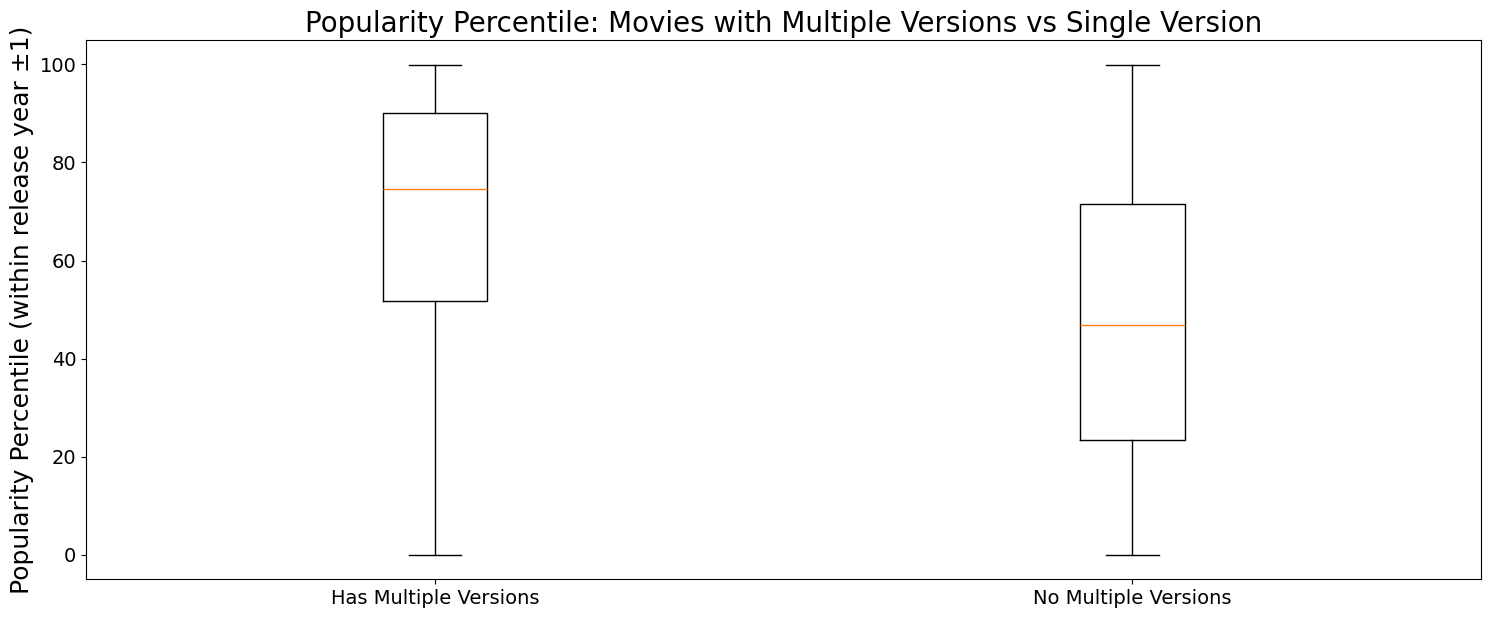

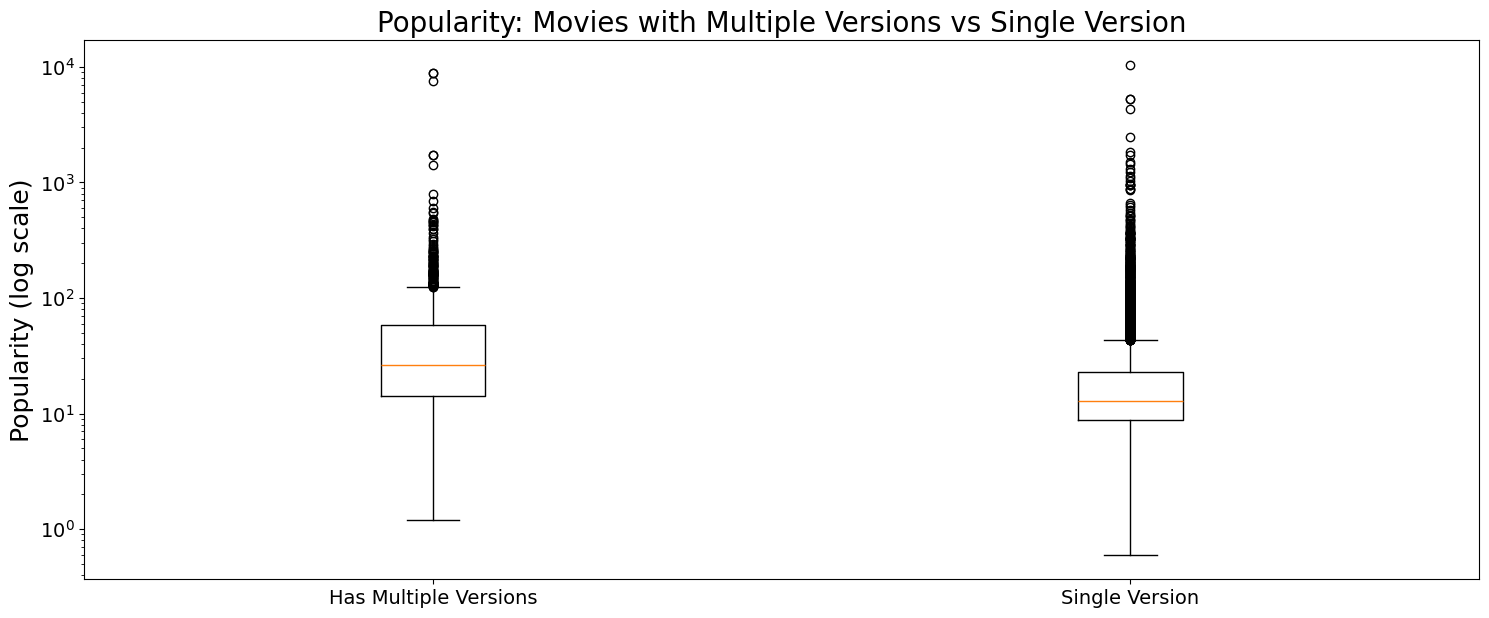

In [6]:
visualizer = Visualizer(df_cleaned)
visualizer.plot_movie_have_multiple_vs_popularity_percentile((18, 7))
visualizer.plot_movie_has_multiple_vs_popularity((18, 7))

<Axes: title={'center': 'Popularity of Movies by Year Bins'}, xlabel='Year Bins', ylabel='Popularity (log scale axis)'>

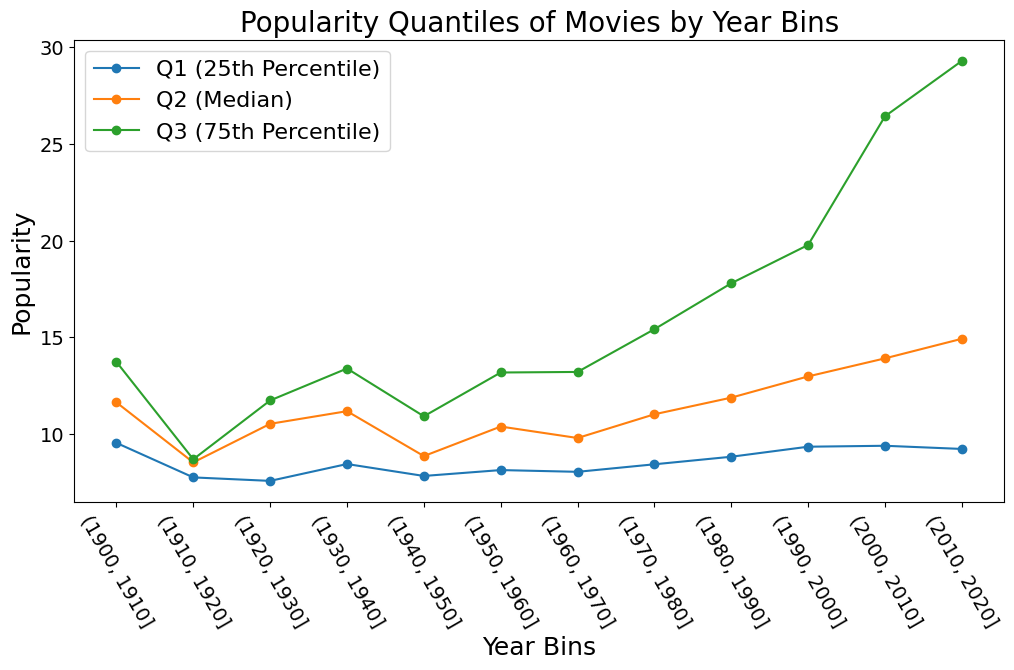

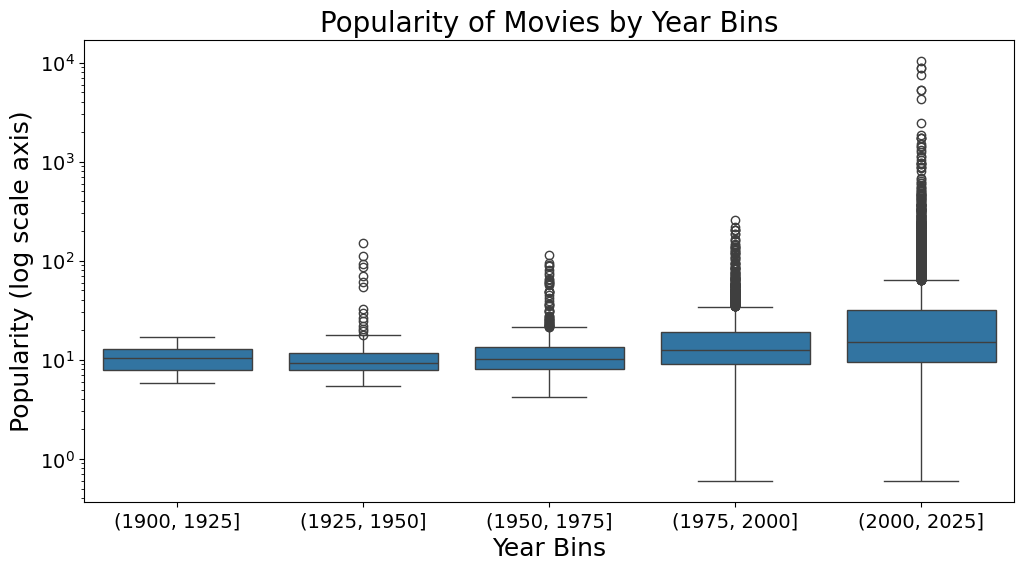

In [7]:
visualizer.plot_q1_q2_q3_popularity_over_period(figsize=(12, 6))
visualizer.plot_popularity_over_period_boxplot(figsize=(12, 6))

<Axes: title={'center': 'Median Popularity vs Number of Genres'}, xlabel='Number of Genres', ylabel='Median Popularity'>

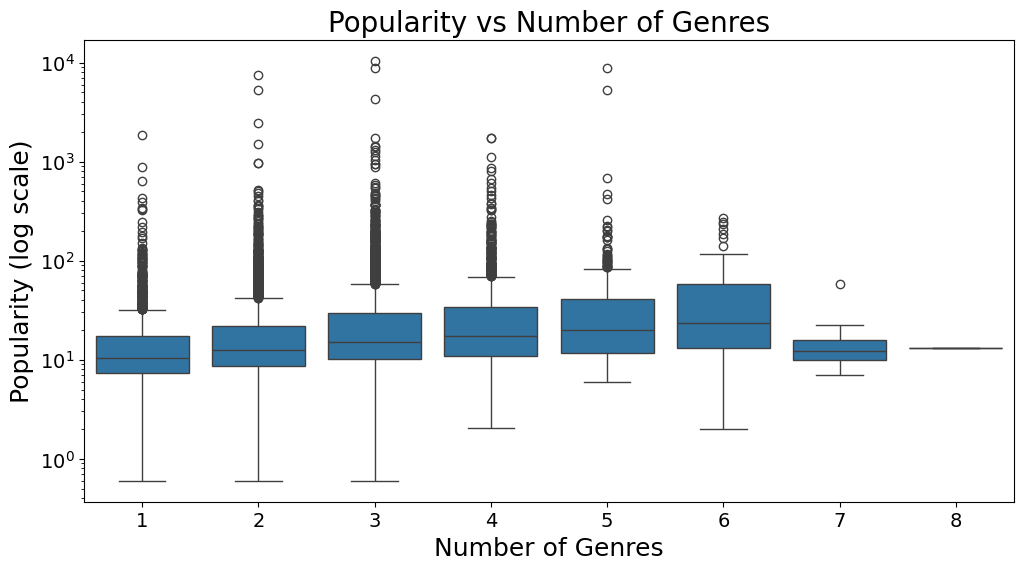

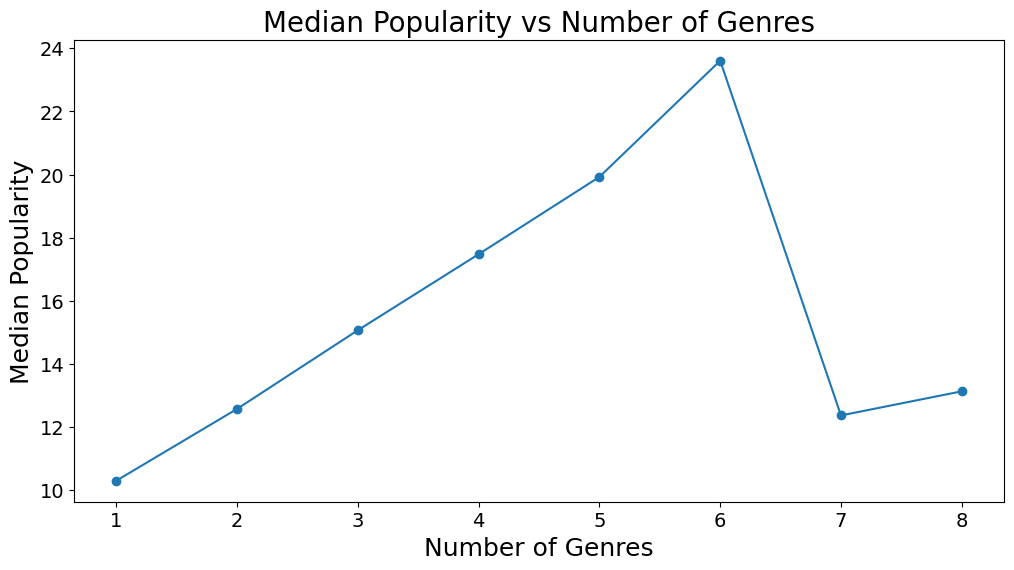

In [8]:
visualizer.plot_number_of_genre_and_popularity_boxplot(figsize=(12, 6))
visualizer.plot_number_of_genre_and_popularity_line_plot(figsize=(12, 6))

<Axes: title={'center': 'Popularity vs Language with Count Annotations\n(Ordered by Median Popularity)'}, xlabel='Language', ylabel='Popularity (log scale)'>

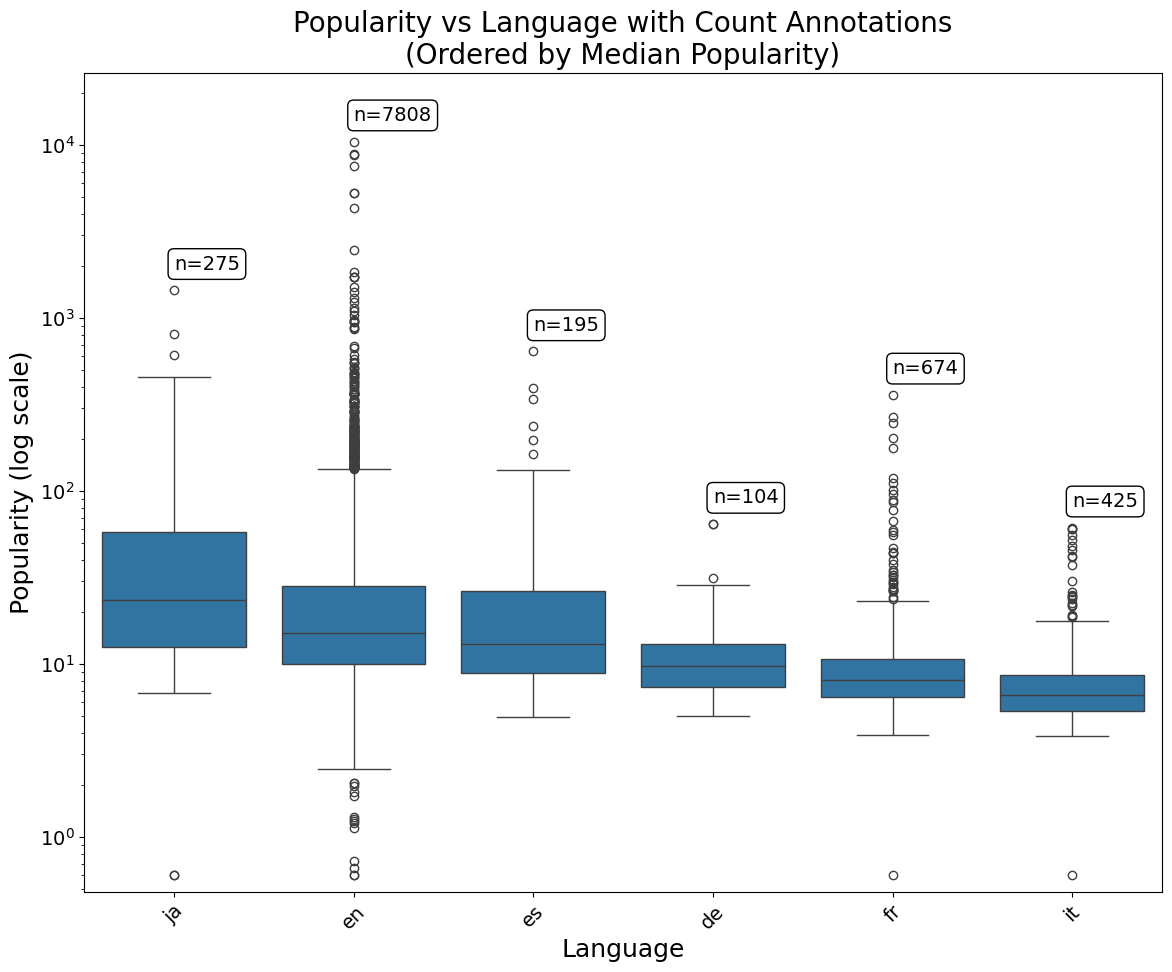

In [9]:
visualizer.plot_language_and_popularity_with_counts(figsize=(12,10))

<Axes: title={'center': 'Popularity Percentile: Original vs Remake Movies'}, ylabel='Popularity Percentile (within release year ±1)'>

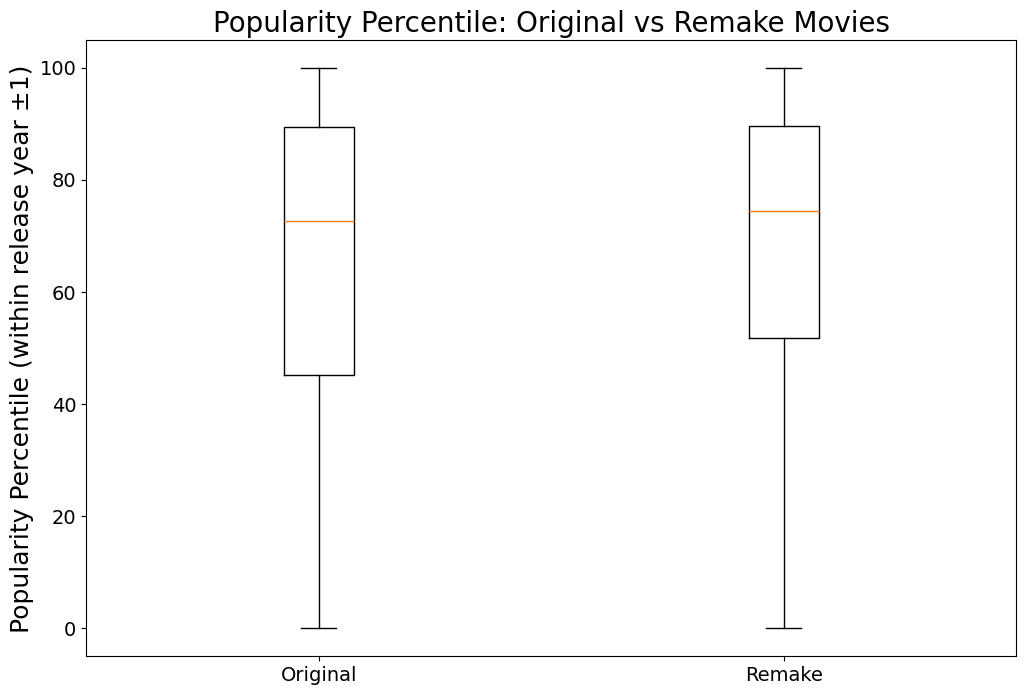

In [10]:
visualizer = Visualizer(df_cleaned)
visualizer.plot_movie_with_remake_percentile(figsize=(12, 8))

In [11]:
# calculate the Cohen's d between the two groups (movies with multiple versions vs those without) based on their popularity percentiles and popularity
def cohen_d(group1, group2):
    """Calculate Cohen's d for two groups."""
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)

    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    if pooled_std == 0:
        return 0.0  # Avoid division by zero; implies no variation in data

    d = (mean1 - mean2) / pooled_std
    return d
def get_percentile(df: pd.DataFrame, year: int, popularity_value: float) -> float:
    """
    Compute the percentile rank (0-100) of a given popularity_value among movies
    released within a window of (year - 1) to (year + 1).
    """
    lower_bound = year - 1
    upper_bound = year + 1
    df = df.copy()
    df['release_year'] = df['release_year'].astype(int)

    window = df[(df['release_year'] >= lower_bound) & (df['release_year'] <= upper_bound)]
    scores = window['popularity'].dropna()

    if scores.empty:
        return float('nan')
    rank = (scores < popularity_value).mean() * 100.0
    return float(rank)

has_multiple_percentiles = []
no_multiple_percentiles = []
has_multiple_popularity = []
no_multiple_popularity = []
for idx, row in df_cleaned.iterrows():
    if pd.isna(row['release_year']) or pd.isna(row['popularity']):
        continue
    percentile = get_percentile(df_cleaned, int(row['release_year']), row['popularity'])
    if row['movie_has_multiple']:
        has_multiple_percentiles.append(percentile)
        has_multiple_popularity.append(row['popularity'])
    else:
        no_multiple_percentiles.append(percentile)
        no_multiple_popularity.append(row['popularity'])
print("Cohen's d for popularity percentiles:", cohen_d(has_multiple_percentiles, no_multiple_percentiles))
print("Cohen's d for raw popularity:", cohen_d(has_multiple_popularity, no_multiple_popularity))    

Cohen's d for popularity percentiles: 0.6999912922447374
Cohen's d for raw popularity: 0.21734326048211863


## Hipotesis dan Validasi 

In [12]:
# ========================
# HIPOTESIS BERDASARKAN SHAP EVIDENCE:
# "Film franchise (movie_has_multiple) memiliki popularitas lebih tinggi"
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
from scipy.stats import mannwhitneyu, chi2_contingency

In [13]:
# ========================
# 1) Load Data dan Focus pada Franchise Effect
# ========================
try:
    df_cleaned
except NameError:
    df_cleaned = pd.read_csv("cleaned_dataset.csv")

df = df_cleaned.copy()

# Feature engineering
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
REF_DATE = pd.Timestamp("2025-09-29")
df["age_years"] = ((REF_DATE - df["release_date"]).dt.days / 365.25).clip(lower=0)
df["summary_len_words"] = df["summary"].astype(str).str.split().str.len()
df["is_english"] = (df["language"] == "en").astype(int)
df["movie_has_multiple"] = df["movie_has_multiple"].astype(int)

# Tambahan: Genre diversity untuk kontrol
df["num_genres"] = df["genre_label"].astype(str).apply(
    lambda x: len([g for g in x.split(",") if g.strip() != ""])
)

print("🎬 ANALISIS FRANCHISE EFFECT TERHADAP POPULARITAS")
print("=" * 60)

🎬 ANALISIS FRANCHISE EFFECT TERHADAP POPULARITAS


<Figure size 1800x1200 with 0 Axes>

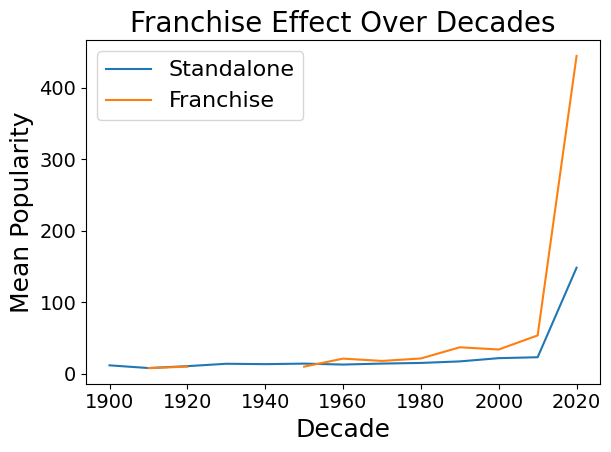

In [14]:
# Plot 4: Franchise effect over time
plt.figure(figsize=(18, 12))
df['decade'] = (df['release_year'] // 10) * 10
decade_franchise = df.groupby(['decade', 'movie_has_multiple'])['popularity'].mean().reset_index()
decade_franchise_pivot = decade_franchise.pivot(
    index='decade',
    columns='movie_has_multiple',
    values='popularity'
)
decade_franchise_pivot.plot(kind='line')
plt.title("Franchise Effect Over Decades", fontsize=TITLE_FONT_SIZE)
plt.xlabel("Decade", fontsize=LABEL_FONT_SIZE)
plt.ylabel("Mean Popularity", fontsize=LABEL_FONT_SIZE)
plt.legend(['Standalone', 'Franchise'], fontsize=LEGEND_FONT_SIZE)
plt.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE)
plt.tight_layout()
plt.show()

In [17]:
# ========================
# 4) Model XGBoost untuk SHAP Analysis
# ========================
numeric_cols = df.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()
engineered = ["age_years", "summary_len_words", "is_english", "num_genres"]
for col in engineered:
    if col not in numeric_cols:
        numeric_cols.append(col)

feature_cols = [c for c in numeric_cols if c != "popularity"]
df_model = df.dropna(subset=feature_cols + ["popularity"]).copy()

X = df_model[feature_cols]
y = df_model["popularity"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# XGBoost Model
xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    objective="reg:squarederror",
    eval_metric="rmse"  # Move eval_metric to model initialization
)
xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"\n🤖 MODEL PERFORMANCE:")
y_pred = xgb.predict(X_test)
print(f"   MAE : {mean_absolute_error(y_test, y_pred):.4f}")
print(f"   R²  : {r2_score(y_test, y_pred):.4f}")


🤖 MODEL PERFORMANCE:
   MAE : 29.6087
   R²  : -0.4483


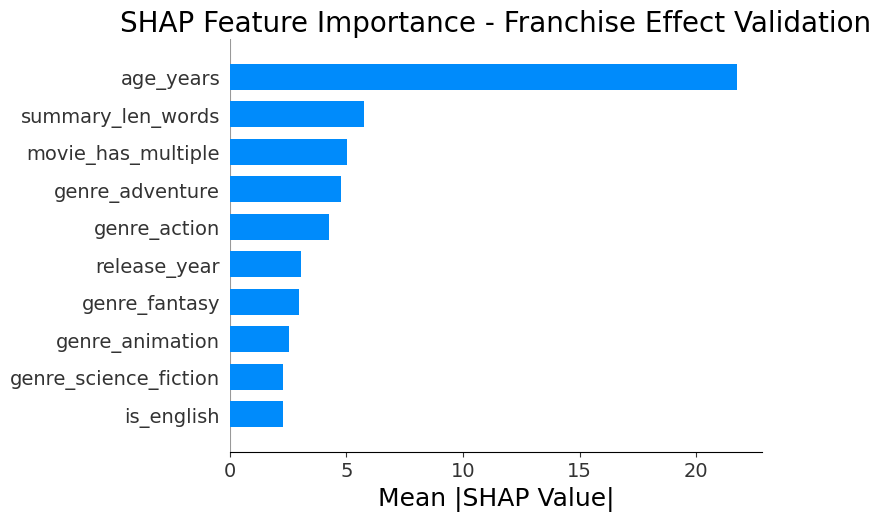

<Figure size 800x600 with 0 Axes>

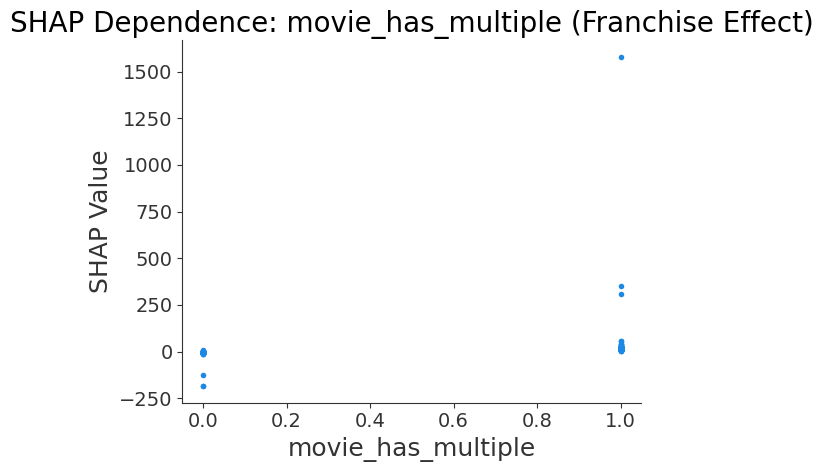

In [18]:
# ========================
# 5) SHAP Analysis - Focus on movie_has_multiple
# ========================
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values, X_test,
    plot_type="bar",
    max_display=10,
    show=False
)
plt.title("SHAP Feature Importance - Franchise Effect Validation", fontsize=TITLE_FONT_SIZE)
plt.xlabel("Mean |SHAP Value|", fontsize=LABEL_FONT_SIZE)
plt.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE)
plt.tight_layout()
plt.show()

# SHAP Dependence Plot untuk movie_has_multiple
plt.figure(figsize=(8, 6))
shap.dependence_plot(
    "movie_has_multiple",
    shap_values,
    X_test,
    interaction_index=None,
    show=False
)
plt.title("SHAP Dependence: movie_has_multiple (Franchise Effect)", fontsize=TITLE_FONT_SIZE)
plt.xlabel("movie_has_multiple", fontsize=LABEL_FONT_SIZE)
plt.ylabel("SHAP Value", fontsize=LABEL_FONT_SIZE)
plt.tick_params(axis='both', which='major', labelsize=TICK_FONT_SIZE)
plt.tight_layout()
plt.show()

In [19]:
# ========================
# 6) Validasi Hipotesis dengan SHAP
# ========================
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

print(f"\n🎬 VALIDASI HIPOTESIS FRANCHISE EFFECT:")
print("=" * 50)

# Ranking movie_has_multiple
feature_importance = np.abs(shap_df).mean().sort_values(ascending=False)
franchise_rank = list(feature_importance.index).index('movie_has_multiple') + 1
franchise_importance = feature_importance['movie_has_multiple']

print(f"🎬 RANKING MOVIE_HAS_MULTIPLE:")
print(f"   Posisi: #{franchise_rank} dari {len(feature_importance)} fitur")
print(f"   SHAP Importance: {franchise_importance:.4f}")

# SHAP values comparison
franchise_shap_mean = shap_df.loc[
    X_test['movie_has_multiple']==1, 'movie_has_multiple'
].mean()
standalone_shap_mean = shap_df.loc[
    X_test['movie_has_multiple']==0, 'movie_has_multiple'
].mean()

print(f"\n🎬 SHAP VALUES COMPARISON:")
print(f"   Mean SHAP Franchise: {franchise_shap_mean:.4f}")
print(f"   Mean SHAP Standalone: {standalone_shap_mean:.4f}")
print(f"   Difference: {franchise_shap_mean - standalone_shap_mean:.4f}")


🎬 VALIDASI HIPOTESIS FRANCHISE EFFECT:
🎬 RANKING MOVIE_HAS_MULTIPLE:
   Posisi: #3 dari 27 fitur
   SHAP Importance: 5.0118

🎬 SHAP VALUES COMPARISON:
   Mean SHAP Franchise: 24.4403
   Mean SHAP Standalone: -2.2350
   Difference: 26.6754


In [25]:
# ========================
# 7) Statistical Test and Final Conclusion
# ========================
# NOTE: This cell should be executed AFTER the SHAP analysis cells
# to ensure all variables (franchise_rank, franchise_shap_mean, etc.) are defined

# Check if SHAP variables exist, if not, skip conclusion
try:
    # Test if SHAP variables exist
    franchise_rank
    franchise_shap_mean
    standalone_shap_mean

    # Calculate additional statistics for conclusion
    franchise_movies = df[df["movie_has_multiple"] == 1]["popularity"]
    standalone_movies = df[df["movie_has_multiple"] == 0]["popularity"]

    franchise_pop_mean = franchise_movies.mean()
    standalone_pop_mean = standalone_movies.mean()

    # Perform statistical test
    from scipy.stats import mannwhitneyu

    statistic, p_value = mannwhitneyu(
        franchise_movies.dropna(), standalone_movies.dropna(), alternative="greater"
    )

    print(f"\n📊 STATISTICAL TEST RESULTS:")
    print("=" * 40)
    print(f"   Mann-Whitney U statistic: {statistic}")
    print(f"   P-value (one-tailed): {p_value}")
    print(f"   Franchise mean popularity: {franchise_pop_mean:.2f}")
    print(f"   Standalone mean popularity: {standalone_pop_mean:.2f}")

except NameError as e:
    print(f"⚠️ ERROR: Please run the SHAP analysis cells first!")
    print(f"   Missing variable: {e}")
    print(
        f"   Execute cells in order: Model Training → SHAP Analysis → This Conclusion"
    )


📊 STATISTICAL TEST RESULTS:
   Mann-Whitney U statistic: 7474905.0
   P-value (one-tailed): 4.881972688480301e-116
   Franchise mean popularity: 75.09
   Standalone mean popularity: 29.16


In [ ]:
try:
    print(f"P-value: {p_value}")
    print(f"P-value (scientific): {p_value:.2e}")

    # Sample sizes
    franchise_count = len(df[df["movie_has_multiple"] == 1])
    standalone_count = len(df[df["movie_has_multiple"] == 0])
    print(f"Franchise movies: {franchise_count}")
    print(f"Standalone movies: {standalone_count}")

    # Significance tests
    print(f"p < 0.05: {p_value < 0.05}")
    print(f"p < 0.01: {p_value < 0.01}")
    print(f"p < 0.001: {p_value < 0.001}")

except NameError:
    print("Run statistical test first")

P-value: 4.881972688480301e-116
P-value (scientific): 4.88e-116
Franchise movies: 1214
Standalone movies: 8769
p < 0.05: True
p < 0.01: True
p < 0.001: True
